In [1]:
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

#plt.style.use('seaborn')
# plt.style.use('fivethirtyeight')

In [2]:
import numpy as np

# Set the seed for reproducibility
seed_value = 0
np.random.seed(seed_value)

# Create the LunarLander environment
env = gym.make('LunarLander-v2')
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)


In [4]:
# Agent that takes random actions
max_episodes = 100

In [5]:
scores = []
actions = range(env.action_space.n)
for i in range(1, max_episodes+1):
    state = env.reset()
    score = 0
    while True:
        action = np.random.choice(actions)
        # state, reward, done, info = env.step(action)
        state, reward, done, truncated , info = env.step(action)
        score += reward
        if done:
            if i % 20 == 0:
                print(f'Episode {i},  score: {score}')
            break

    scores.append(score)

/home/hostage/anaconda3/envs/AI_Gym/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 20,  score: -296.03811344877596
Episode 40,  score: -248.06410200696908
Episode 60,  score: -119.79158561563227
Episode 80,  score: -113.07408611229789
Episode 100,  score: -252.31260133368875


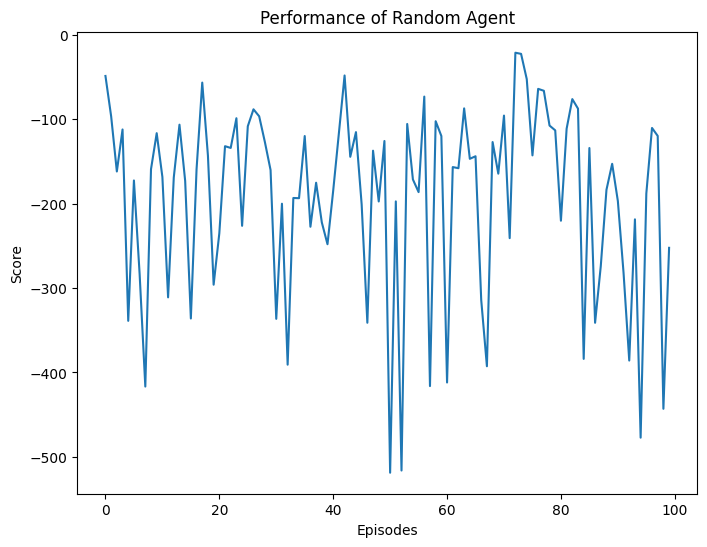

In [6]:
# Show random agent's performance
plt.figure(figsize=(8,6))
plt.plot(range(max_episodes), scores)
plt.title('Performance of Random Agent')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.show()

In [7]:
# Average score
print('Average score of random agent over {} episodes: {:.2f}'.format(max_episodes, np.mean(scores)))

Average score of random agent over 100 episodes: -192.20


In [8]:
# Use cuda if available else use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        """
        Build a fully connected neural network
        
        Parameters
        ----------
        state_size (int): State dimension
        action_size (int): Action dimension
        seed (int): random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_size)  
        
    def forward(self, x):
        """Forward pass"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x        

In [10]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        """
        Replay memory allow agent to record experiences and learn from them
        
        Parametes
        ---------
        buffer_size (int): maximum size of internal memory
        batch_size (int): sample size from experience
        seed (int): random seed
        """
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add experience"""
        # state = state[state != "{}"]
        # next_state = next_state[0] if next_state is not None else None
        # print("\nstate:", state)
        # print("\nnext_state:", next_state)

        experience = self.experience(state, action, reward, next_state, done)
        # print("\nexperience: ", experience)
        self.memory.append(experience)
                
    def sample(self):
        """ 
        Sample randomly and return (state, action, reward, next_state, done) tuple as torch tensors 
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        # print("\ntest: ", [experience.state for experience in experiences if experience is not None])
        # Convert to torch tensors
        states = torch.from_numpy(np.vstack([experience.state for experience in experiences if experience is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([experience.action for experience in experiences if experience is not None])).long().to(device)        
        rewards = torch.from_numpy(np.vstack([experience.reward for experience in experiences if experience is not None])).float().to(device)        
        next_states = torch.from_numpy(np.vstack([experience.next_state for experience in experiences if experience is not None])).float().to(device)  
        # Convert done from boolean to int
        dones = torch.from_numpy(np.vstack([experience.done for experience in experiences if experience is not None]).astype(np.uint8)).float().to(device)        
        # print("finished samples\n")
        # print("\n", states, actions, rewards, next_states, dones)
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

In [11]:
BUFFER_SIZE = int(1e5) # Replay memory size
BATCH_SIZE = 64         # Number of experiences to sample from memory
GAMMA = 0.99            # Discount factor
TAU = 1e-3              # Soft update parameter for updating fixed q network
LR = 1e-4               # Q Network learning rate
UPDATE_EVERY = 4        # How often to update Q network

class DQNAgent: 
    def __init__(self, state_size, action_size, seed):
        """
        DQN Agent interacts with the environment, 
        stores the experience and learns from it
        
        Parameters
        ----------
        state_size (int): Dimension of state
        action_size (int): Dimension of action
        seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        # Initialize Q and Fixed Q networks
        self.q_network = QNetwork(state_size, action_size, seed).to(device)
        self.fixed_network = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters())
        # Initiliase memory 
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.timestep = 0
        

    def step(self, state, action, reward, next_state, done):
        """
        Update Agent's knowledge
        
        Parameters
        ----------
        state (array_like): Current state of environment
        action (int): Action taken in current state
        reward (float): Reward received after taking action 
        next_state (array_like): Next state returned by the environment after taking action
        done (bool): whether the episode ended after taking action
        """
        self.memory.add(state, action, reward, next_state, done)
        self.timestep += 1
        if self.timestep % UPDATE_EVERY == 0:
            if len(self.memory) > BATCH_SIZE:
                sampled_experiences = self.memory.sample()
                self.learn(sampled_experiences)
        
    def learn(self, experiences):

        states, actions, rewards, next_states, dones = experiences
        # Get the action with max Q value
        action_values = self.fixed_network(next_states).detach()
        # Notes
        # tensor.max(1)[0] returns the values, tensor.max(1)[1] will return indices
        # unsqueeze operation --> np.reshape
        # Here, we make it from torch.Size([64]) -> torch.Size([64, 1])
        max_action_values = action_values.max(1)[0].unsqueeze(1)
        
        # If done just use reward, else update Q_target with discounted action values
        Q_target = rewards + (GAMMA * max_action_values * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)
        
        # Calculate loss
        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update weights
        self.optimizer.step()
        
        # Update fixed weights
        self.update_fixed_network(self.q_network, self.fixed_network)
        
    def update_fixed_network(self, q_network, fixed_network):
        """
        Update fixed network by copying weights from Q network using TAU param
        
        Parameters
        ----------
        q_network (PyTorch model): Q network
        fixed_network (PyTorch model): Fixed target network
        """
        for source_parameters, target_parameters in zip(q_network.parameters(), fixed_network.parameters()):
            target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)
        
        
    def act(self, state, eps=0.0):
        """
        Choose the action
        
        Parameters
        ----------
        state (array_like): current state of environment
        eps (float): epsilon for epsilon-greedy action selection
        """
        if isinstance(state, tuple):  # Check if state is a tuple
            state = state[0]  # Assuming the actual state is the first element of the tuple
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # set the network into evaluation mode 
        self.q_network.eval()
        # perform forward pass
        with torch.no_grad():
            action_values = self.q_network(state)
        # set the network back into training mode
        self.q_network.train()
        
        if np.random.rand() < eps:
            return np.random.randint(self.action_size)
        else:
            return torch.argmax(action_values, dim=1).item()
        
    def checkpoint(self, filename):
        torch.save(self.q_network.state_dict(), filename)

In [12]:
import torch
import torch.nn.functional as F

class DDQNAgent(DQNAgent):
    def __init__(self, state_size, action_size, seed):
        super(DDQNAgent, self).__init__(state_size, action_size, seed)
        self.q_network_target = QNetwork(state_size, action_size, seed).to(device)
        self.update_fixed_network(self.q_network, self.q_network_target)

    def act(self, state, eps=0.0):
        if isinstance(state, tuple):  # Check if state is a tuple
            state = state[0]  # Assuming the actual state is the first element of the tuple
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.q_network.eval()
        with torch.no_grad():
            action_values = self.q_network(state)
        self.q_network.train()

        if np.random.rand() < eps:
            return np.random.randint(self.action_size)
        else:
            return torch.argmax(action_values, dim=1).item()

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Use q_network to select actions for the next states
        next_actions = self.q_network(next_states).argmax(1).unsqueeze(1)

        # Use q_network_target to evaluate the Q values for the next_states and next_actions
        q_targets_next = self.q_network_target(next_states).gather(1, next_actions)

        Q_target = rewards + (GAMMA * q_targets_next * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update fixed weights
        self.update_fixed_network(self.q_network, self.q_network_target)

    def update_fixed_network(self, q_network, fixed_network):
        for source_parameters, target_parameters in zip(q_network.parameters(), fixed_network.parameters()):
            target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.timestep += 1
        if self.timestep % UPDATE_EVERY == 0:
            if len(self.memory) > BATCH_SIZE:
                sampled_experiences = self.memory.sample()
                self.learn(sampled_experiences)

    def checkpoint(self, filename):
        torch.save(self.q_network.state_dict(), filename)


In [13]:
BUFFER_SIZE = int(1e5) # Replay memory size
BATCH_SIZE = 64         # Number of experiences to sample from memory
GAMMA = 0.99            # Discount factor
TAU = 1e-3              # Soft update parameter for updating fixed q network
LR = 1e-4               # Q Network learning rate
UPDATE_EVERY = 4        # How often to update Q network

MAX_EPISODES = 2000  # Max number of episodes to play
MAX_STEPS = 1000     # Max steps allowed in a single episode/play
ENV_SOLVED = 100     # MAX score at which we consider environment to be solved
PRINT_EVERY = 25    # How often to print the progress

# Epsilon schedule

EPS_START = 1.0      # Default/starting value of eps
EPS_DECAY = 0.999    # Epsilon decay rate
EPS_MIN = 0.01       # Minimum epsilon 

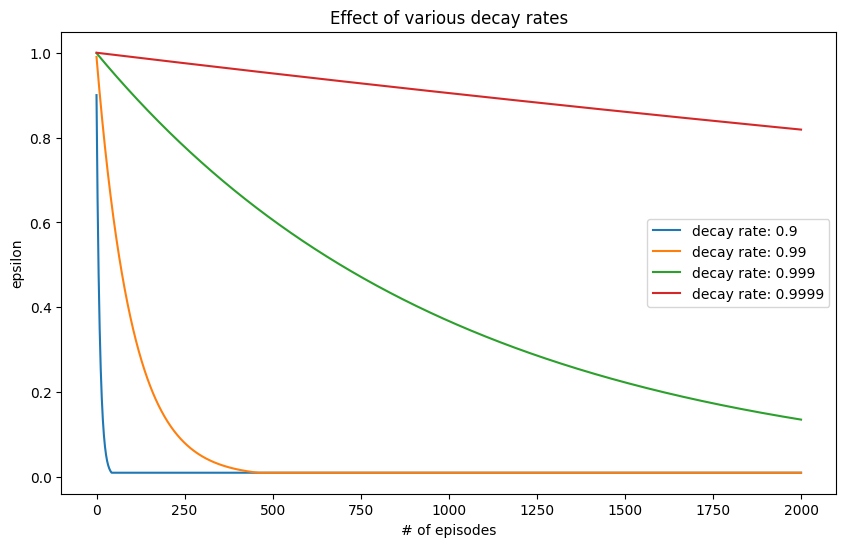

In [14]:
EPS_DECAY_RATES = [0.9, 0.99, 0.999, 0.9999]
plt.figure(figsize=(10,6))

for decay_rate in EPS_DECAY_RATES:
    test_eps = EPS_START
    eps_list = []
    for _ in range(MAX_EPISODES):
        test_eps = max(test_eps * decay_rate, EPS_MIN)
        eps_list.append(test_eps)          

    plt.plot(eps_list, label=f'decay rate: {decay_rate}')

plt.title('Effect of various decay rates')
plt.legend(loc='best')
plt.xlabel('# of episodes')
plt.ylabel('epsilon')
plt.show()

In [15]:
# Get state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(f'State size: {state_size}, action size: {action_size}')

State size: 8, action size: 4


In [16]:
dqn_agent = DQNAgent(state_size, action_size, seed=0)

Train with DQN-Agent

In [17]:
start = time()
scores = []
# Maintain a list of last 100 scores
scores_window = deque(maxlen=100)
eps = EPS_START
for episode in range(1, MAX_EPISODES + 1):
    state = env.reset()
    score = 0
    for _ in range(MAX_STEPS):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, truncated , info = env.step(action)
        # next_state, reward, done, info = env.step(action)
        # print("Type", type(cleaned_states))
        if isinstance(state, np.ndarray):
            dqn_agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break

        eps = max(eps * EPS_DECAY, EPS_MIN)
        if episode % PRINT_EVERY == 0:
            mean_score = np.mean(scores_window)
            print('\r Progress {}/{}, average score:{:.2f}'.format(episode, MAX_EPISODES, mean_score), end="")
        if score >= ENV_SOLVED:
            mean_score = np.mean(scores_window)
            print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
            sys.stdout.flush()
            dqn_agent.checkpoint('solved_100_dqn.pth')
            break

    scores_window.append(score)
    scores.append(score)

end = time()
print(f'\nTook {end - start} seconds')

Environment solved in 2000 episodes, average score: 102.18
Took 1850.8681316375732 seconds


In [18]:
dqn_agent.checkpoint('solved_100_dqn.pth')

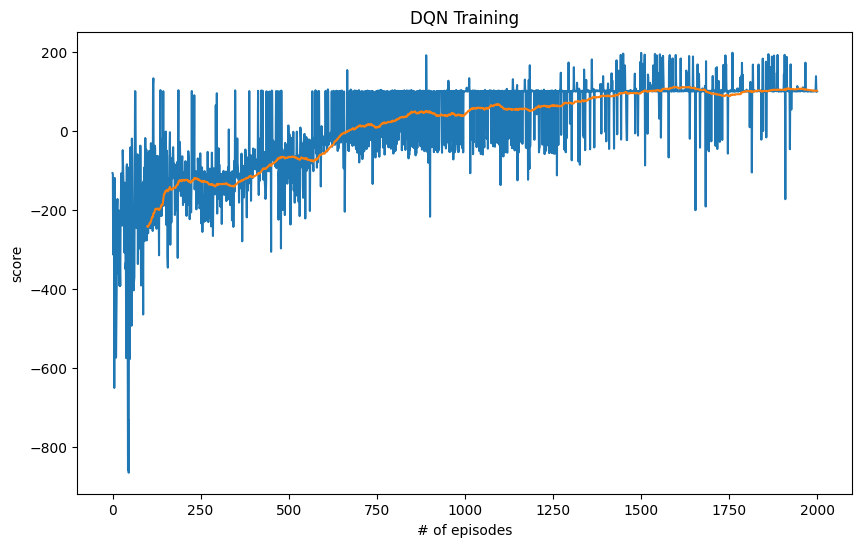

In [19]:
plt.figure(figsize=(10,6))
plt.plot(scores)
# A bit hard to see the above plot, so lets smooth it (red)
plt.plot(pd.Series(scores).rolling(100).mean())
plt.title('DQN Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

Train with DDQN Agent

In [20]:
ddqn_agent = DDQNAgent(state_size, action_size, seed=0)

In [21]:
start = time()
scores = []
# Maintain a list of last 100 scores
scores_window = deque(maxlen=100)
eps = EPS_START
for episode in range(1, MAX_EPISODES + 1):
    state = env.reset()
    score = 0
    for _ in range(MAX_STEPS):
        action = ddqn_agent.act(state, eps)
        next_state, reward, done, truncated , info = env.step(action)
        # next_state, reward, done, info = env.step(action)
        # print("Type", type(cleaned_states))
        if isinstance(state, np.ndarray):
            ddqn_agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break

        eps = max(eps * EPS_DECAY, EPS_MIN)
        if episode % PRINT_EVERY == 0:
            mean_score = np.mean(scores_window)
            print('\r Progress {}/{}, average score:{:.2f}'.format(episode, MAX_EPISODES, mean_score), end="")
        if score >= ENV_SOLVED:
            mean_score = np.mean(scores_window)
            print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
            sys.stdout.flush()
            ddqn_agent.checkpoint('solved_100_ddqn.pth')
            break

    scores_window.append(score)
    scores.append(score)

end = time()
print(f'\nTook {end - start} seconds')

Environment solved in 2000 episodes, average score: 99.816
Took 1987.585771560669 seconds


In [22]:
ddqn_agent.checkpoint('solved_100_ddqn.pth')

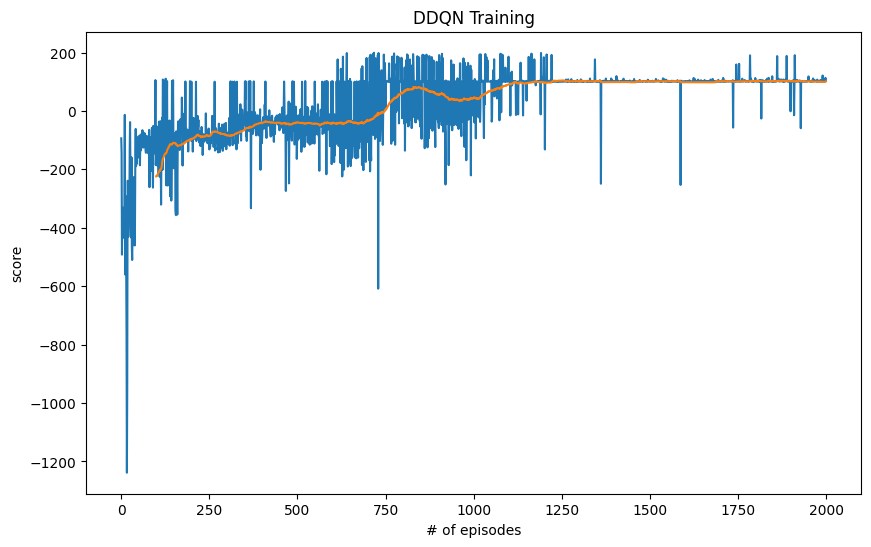

In [23]:
plt.figure(figsize=(10,6))
plt.plot(scores)
# A bit hard to see the above plot, so lets smooth it (red)
plt.plot(pd.Series(scores).rolling(100).mean())
plt.title('DDQN Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

In [24]:
dqn_agent.q_network.load_state_dict(torch.load('solved_100_dqn.pth'))

<All keys matched successfully>

In [25]:
for i in range(5):
    score = 0
    state = env.reset()
    while True:
        action = dqn_agent.act(state)
        next_state, reward, done, truncated , info = env.step(action)
        state = next_state        
        score += reward        
        if done:
            break
    print(f'episode: {i} scored {score}')
env.close()

episode: 0 scored 203.98969385190028
episode: 1 scored 8.702760393208607
episode: 2 scored 212.31903841210243
episode: 3 scored 200.20908264521216
episode: 4 scored 245.99020176805882


In [26]:
ddqn_agent.q_network.load_state_dict(torch.load('solved_100_ddqn.pth'))

FileNotFoundError: [Errno 2] No such file or directory: 'solved_100.ddqn'

In [ ]:
for i in range(5):
    score = 0
    state = env.reset()
    while True:
        action = ddqn_agent.act(state)
        next_state, reward, done, truncated , info = env.step(action)
        state = next_state        
        score += reward        
        if done:
            break
    print(f'episode: {i} scored {score}')
env.close()